# Initial data processing for TCRM

Before we simulate synthetic TC events, we need to perform some basic processing of the input TC observation database. There's a significant amount of inconsistency and missing data in the best-track archives, and so we need to separate out the required data and ensure there is no invalid data in there. 

This notebook will execute the initial processing steps that TCRM uses, so that we can then use the resulting data in subsequent notebooks that explore in more detail the inner workings of TCRM.

In [1]:
%matplotlib notebook
import os
import io
import sys

from tcrm import doOutputDirectoryCreation
from DataProcess.DataProcess import DataProcess
from Utilities.config import ConfigParser
from Utilities.parallel import attemptParallel, disableOnWorkers

Because TCRM is often executed in a parallel processing environment, we need to have methods to ensure that some parts of the code only execute on a single processor, e.g. directory creation, to avoid race conditions and multiple processes attempting to read/write from one file. This next bit of code helps to handle that problem. You don't need to know the details of what's going on here. 

In [2]:
global pp
pp = attemptParallel()
import atexit
atexit.register(pp.finalize)

<bound method DummyPypar.finalize of <Utilities.parallel.DummyPypar object at 0x7f2e79f19990>>

In [8]:
configstr = """
[DataProcess]
InputFile=/home/547/cxa547/tcrm/input/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=False

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':100.,'xMax':165.,'yMin':-35.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=10000
YearsPerSimulation=1
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /home/547/cxa547/tcrm/input/landmask.nc
mslpfile = /home/547/cxa547/tcrm/MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/g/data/w85/TCRM_data/tcrm2.1/

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/g/data/w85/TCRM_data/tcrm2.1/log/tcrm2.1.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /home/547/cxa547/tcrm/input/
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /home/547/cxa547/tcrm/MSLP
filename = slp.day.ltm.nc
"""

The following piece of code sets up an instance of Python's `ConfigParser` configuration module, with a couple of minor modifications for TCRM. We then read in the string version of the configuration detailed above. We could equally pass the `config.readfp()` method the name of a complete TCRM configuration file, but it's easier to show how configuration changes affect the way the model operates.

In [9]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

We need to create a directory for the output to be stored in. If the specified directory already exists, the data that exists in that folder will be overwritten. If the output directory cannot be created, either due to permission errors or because you've specified a path that is unreachable, then the code will raise an exception, indicating the reason for the failure.

In [ ]:
doOutputDirectoryCreation(configstr)

These two lines do the majority of the work of processing the input file. The first sets up a `DataProcess` object, which has a single public method (but many private methods) to perform the processing

In [ ]:
dp = DataProcess(configstr)
dp.processData()

You might see a couple of "WARNING" messages appear indicating that certain data fields are not available. These are optional, not essential fields. If essential fields are missing, then the `processData` method will raise an exception and stop execution.

So now, what has this produced? We can check the files that now exist in the output path:

In [ ]:
outputPath = config.get('Output', 'Path')
processPath = os.path.join(outputPath, 'process')
dirlist = [f for f in os.listdir(processPath) if os.path.isfile(os.path.join(processPath, f))]
dirlist

The listing shows a number of files, with no extension. These are text files, some in a csv format, that are read by different processes at different stages later in the execution of TCRM. 

#### Questions:
1. Open the 'cyclone_tracks' file in a text editor and check out the contents. What might the first column represent? What about the other columns?
2. Open the 'jday_genesis' file and see if you can dduce what it contains.



### Plotting the output from `DataProcess`

To let you visually inspect the data produced by `DataProcess.processData`, there's a simple function that plots the data for you. We'll execute the function here, then display the contents in the notebook, using some simple IPython functions.

In [ ]:
from tcrm import doDataPlotting
from ipywidgets import interact, Dropdown
from IPython.display import Image, display

doDataPlotting(configstr)

In [ ]:
statsPlotPath = os.path.join(outputPath, 'plots/stats')
imglist = os.listdir(statsPlotPath)

def showImg(imgfile):
    x = Image(os.path.join(statsPlotPath, imgfile))
    display(x)
    
imgDropdown = Dropdown(options=imglist, value=imglist[0], description="File name")
interact(showImg, imgfile=imgDropdown)

#### Questions:

1. Compare the figures for the 'pressure' and 'pressure_rate' results. The x-axis is the observations at one time, and the y-axis is the observation at the previous time step, essentially the autocorrelation. What can you say about the pressure variable? What about the pressure rate of change? 

2. 

## Statistical processing 

We now move on to the step of calculating the gridded statistics across the domain. In this step, we calculate the mean, variances and lag-1 autocorrelations for all the key variables that we use in generating synthetic tracks.



In [5]:
from DataProcess.CalcTrackDomain import CalcTrackDomain
from StatInterface import StatInterface

First, we calculate the domain of the tracks that enter the region that we want to cover in our simulation. 

In [10]:
CalcTD = CalcTrackDomain(configstr)
trackDomain = CalcTD.calcDomainFromFile()

First see what this means. The configuration has defined a region for which we want to run the model. But there are TC tracks that enter this region which start outside the region. If we were to exclude those events, we would underestimate the frequency of events, as well as have an incomplete record of the behavoiur of cyclones in the domain. 

In [11]:
# need to add the historical tracks:
from Utilities.loadData import loadTrackFile

trackFile = config.get('DataProcess', 'InputFile')
source = config.get('DataProcess', 'Source')

tracks = loadTrackFile(configstr, trackFile, source)

<IPython.core.display.Javascript object>


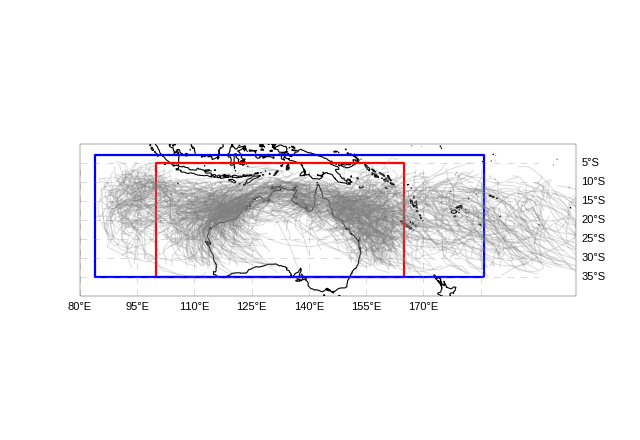

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import shapely.geometry as sg
gridLimit = eval(config.get('Region', 'gridLimit'))
fig = plt.figure()

prj = ccrs.PlateCarree(central_longitude=180)
prj0 = ccrs.PlateCarree(central_longitude=0)
ax = plt.axes(projection=prj)
ax.set_extent([120, 200, -30, -5], prj0)       

ax.coastlines(resolution='50m', color='black', linewidth=1)
simBox = sg.box(minx=gridLimit['xMin'], maxx=gridLimit['xMax'],
                   miny=gridLimit['yMin'], maxy=gridLimit['yMax'])
trackBox = sg.box(minx=trackDomain['xMin'], maxx=trackDomain['xMax'],
                     miny=trackDomain['yMin'], maxy=trackDomain['yMax'])

for t in tracks:
    if t.inRegion(trackDomain):
        plt.plot(t.Longitude, t.Latitude, color='gray', linewidth=1, transform=prj0, alpha=0.25)
        
ax.add_geometries([simBox], prj0, facecolor='', 
                   edgecolor='red', linewidth=2)
ax.add_geometries([trackBox], prj0, facecolor='', 
                   edgecolor='blue', linewidth=2)
ax.set_extent([80, 210, -40, 0], prj0)       
gl = ax.gridlines(crs=prj0, draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator(range(80, 210, 15))
gl.ylocator = mticker.FixedLocator(range(-40, 0, 5))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

fig.show()


In red is the region we want the simulation to cover (the "simulation domain"). In grey are all the tracks that *enter* the red box. The blue box is the outer limit of the tracks that enter the simulation domain. We actually need to simulate tracks across the blue region (the "track domain"), to ensure we get an accurate representation of the TC activity in the simulation domain. 

In [13]:
trackBox.bounds

(84.0, -35.0, 186.0, -3.0)

We then use that new track domain to define the grid for which we will calculate the statistics.

In [ ]:
statInterface = StatInterface.StatInterface(configstr, autoCalc_gridLimit=trackDomain)
statInterface.kdeOrigin()
statInterface.kdeGenesisDate()
statInterface.cdfCellBearing()
statInterface.cdfCellSpeed()
statInterface.cdfCellPressure()
statInterface.calcCellStatistics()